Spectroscopic data reduction in six simple steps. The steps performed in this notebook are shown in **bold.**

Step 1: Trim and subtract bias from all the data.

Step 2: Flatfield the data.

Step 3: Construct a comparison lamp image from separate He and Ne lamps.

**Step 4: Fit the wavelength solution to the lamp composite.** 

Step 5: Extract the 1-D spectrum and its wavelength solution.

Step 6: Apply a relative flux calibration. 

$\rightarrow$ now you are ready to do a bit of analysis.

Piece of cake. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from astropy import units as u
from astropy.io import fits
from astropy.modeling.polynomial import Polynomial1D, Polynomial2D, Chebyshev2D
from astropy.modeling.models import Gaussian1D, Linear1D, Chebyshev1D
from astropy.modeling.fitting import LinearLSQFitter, LevMarLSQFitter, TRFLSQFitter
from astropy.io import ascii
from astropy.table import Table

from scipy import ndimage

# getting used to wavelength calibration

The idea behind wavelength calibration is simple: we're taking a spectrum of a lamp with known emission lines. This allows us to derive the relationship between wavelength and spatial position, or $\lambda(x,y)$. 

Doing wavelength calibration is more challenging in practice because the observer has to match the observed spectral lines to an atlas of known lines which can be challenging for lamp spectra with many lines. To get a feel for how this process works, let's start with just a few lines observed with the He lamp. 

In [2]:
path = '/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/sandbox/'
# the long He lamp that has been trimmed and bias-subtracted 
lab2tb_he_long = fits.open(path+'lab2tb_he_long.fits')[0].data

In [3]:
# Get the median along the spectral direction
spec = np.median(lab2tb_he_long, axis=0)
# define the x-axis in pixel space 
xspec = np.arange(len(spec))

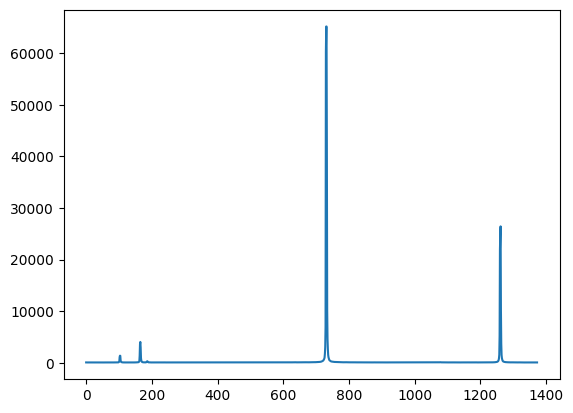

In [4]:
plt.plot(spec)

Next, we need a list of known He I lines, preferably with the relative intensities to make it a bit easier to determine which line is which. 

In [5]:
# pull the He I line list
HeI_lines = Table.read(path+'../hei_linelist.dat', format='ascii', data_start=1,
                      names=['wave', 'ints'])

Print out the list to see the wavelength in Angstroms and the relative intensity. 

In [6]:
HeI_lines.pprint_all()

   wave    ints
--------- -----
2818.1895  10.0
2945.1199  10.0
3013.7332  40.0
  3187.75  20.0
3819.5928  10.0
3888.6313 500.0
3964.7104  20.0
 4026.171  50.0
4120.7925  12.0
4387.9004  10.0
4471.4487 200.0
4713.1084  30.0
 4921.889  20.0
5015.6343 100.0
 5047.693  10.0
 5875.559 500.0
 6678.074 100.0
7281.2607  50.0


Next, we have to figure out which emission lines in our Helium spectrum match to the He I lines in the list. We can make a first cut based on the approximate wavelength range of our observations - in this case, most of the optical spectrum. Then, we make an educated guess based on the known wavelengths and relative intensities of the He I lines. 

In [7]:
# guess the central position of the non-saturated lines 
peaks = [103, 165, 186, 1262]
guessed_wavelengths = [4921.889, 5015.6343, 5047.693, 6678.074]

We can improve the x pixel values by using the intensity-weighted position (moment 1). 

In [8]:
npixels = 15
peaks_refined = [np.average(xspec[g-npixels:g+npixels],
                            weights=spec[g-npixels:g+npixels] - np.median(spec))
                 for g in peaks]
peaks_refined

[103.35643135556518,
 164.96532246532246,
 183.57129714811407,
 1261.3157305952036]

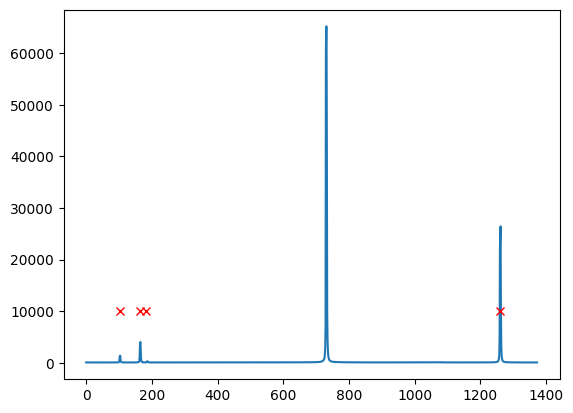

In [9]:
plt.plot(spec)
plt.plot(peaks_refined, [10000]*len(peaks_refined), 'x', color='red')

We exclude the brightest line from our fit because it's saturated (so the line profile is flat-topped and the line center is poorly constrained). We can use this later as a sanity check -- based on the relative intensities of the lines, we know the approximate wavelength to expect for this bright line. 

We only have a few points, so let's fit a linear model. 

In [10]:
linfitter = LinearLSQFitter()
linmodel = Linear1D()
linfit_linmodel = linfitter(model=linmodel, x=peaks_refined, y=guessed_wavelengths)
wavelengths = linfit_linmodel(np.arange(len(spec))) * u.AA
linfit_linmodel

<Linear1D(slope=1.51544018, intercept=4766.75621942)>

Plot the spectrum with the newly-derived wavelength solution to see how we did. 

(-100.0, 10000.0)

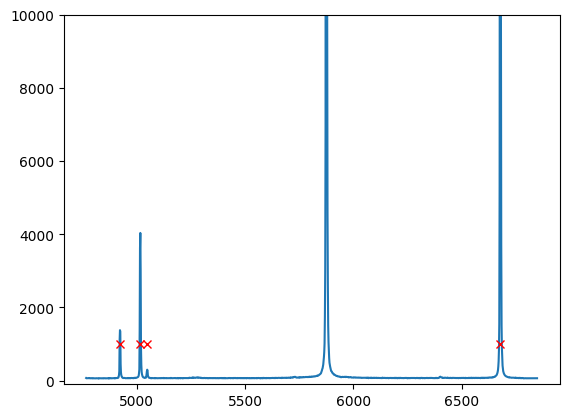

In [11]:
plt.plot(wavelengths, spec)
plt.plot(guessed_wavelengths, [1000]*4, 'x', color='red')
plt.ylim([-100,10000])

Let's look at how well a linear model fits the data. 

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_3918/83463493.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda(x)$")


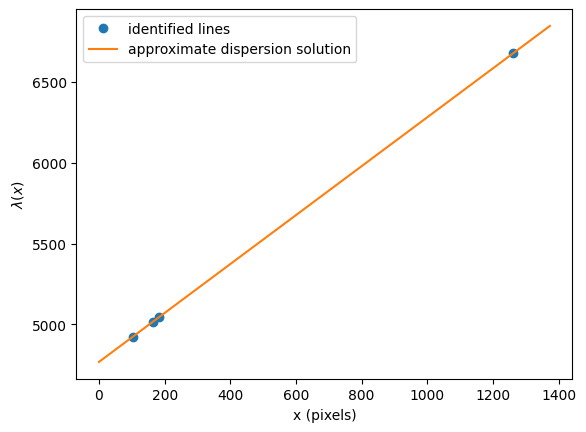

In [12]:
# input guesses 
plt.plot(peaks_refined, guessed_wavelengths, 'o')
# derived wavelength solution
plt.plot(np.arange(len(spec)), wavelengths)
plt.ylabel("$\lambda(x)$")
plt.xlabel("x (pixels)")

plt.legend(['identified lines', 'approximate dispersion solution'])

The last things to check is whether this wavelength solution correctly identifies the saturated line as the brightest line in this portion of the He I spectrum (the line with the highest relative intensity).

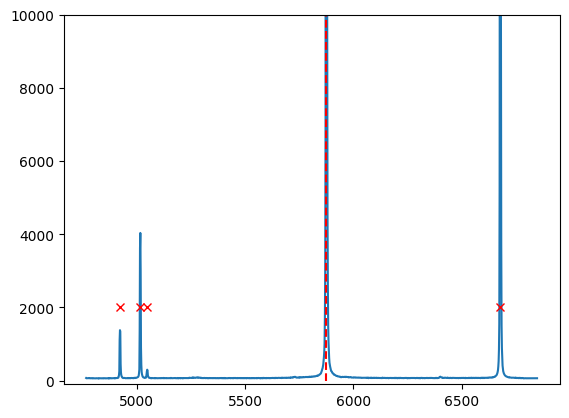

In [13]:
plt.plot(wavelengths, spec)
plt.plot(guessed_wavelengths, [2000]*4, 'x', color='red')
plt.ylim([-100,10000])
plt.plot([5875.559,5875.559],[0,10000], color='red', linestyle='dashed')

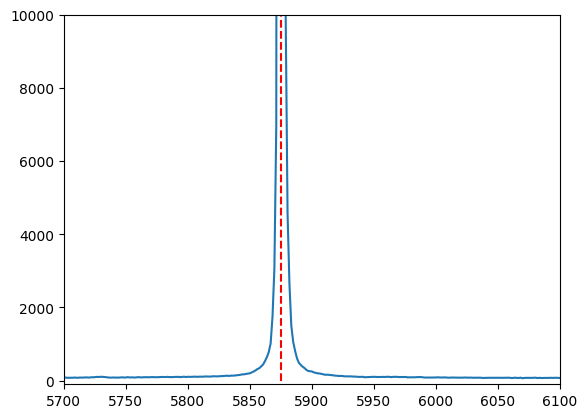

In [14]:
plt.plot(wavelengths, spec)
plt.plot(guessed_wavelengths, [2000]*4, 'x', color='red')
plt.xlim([5700,6100])
plt.ylim([-100,10000])
plt.plot([5875.559,5875.559],[0,10000], color='red', linestyle='dashed')

Now that we have a feel for how wavelength calibration works, let's do the full composite lamp. It has more lines giving us a better fit and a more robust wavelength solution. 

# Fit the full calibration spectrum 

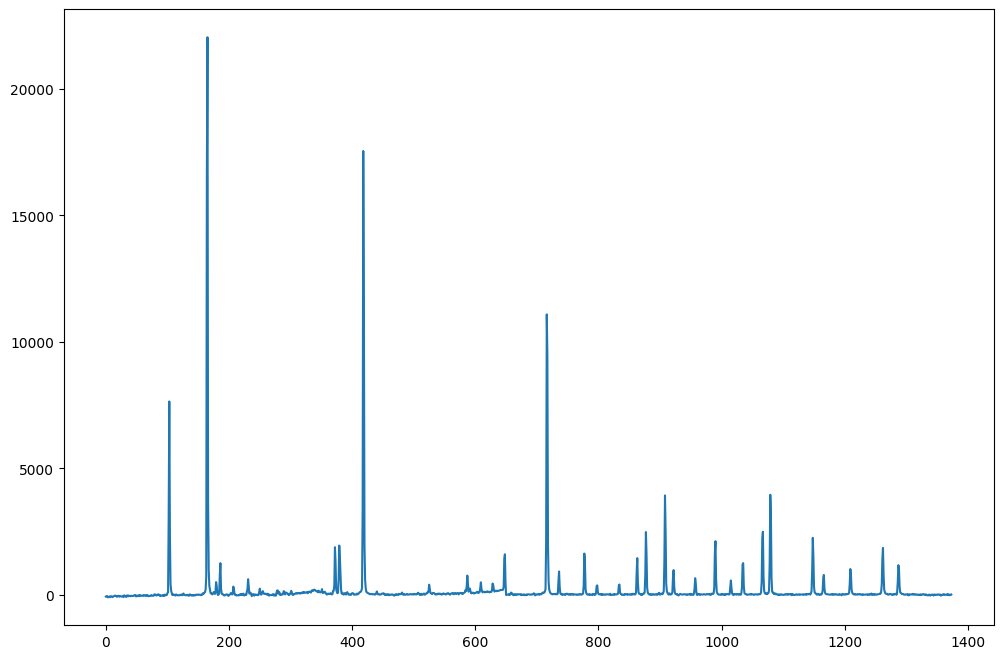

In [15]:
# read in our combined lamp spectrum 
spectrum2D = fits.open("lamp_spec.fits")[0].data

# Take a slice along the middle of the 2D spectrum
middle = 300 
spectrum = np.median(spectrum2D[middle-10:middle+10,:], axis=0)
xaxis = np.arange(len(spectrum))

plt.figure(figsize=(12,8))
plt.plot(xaxis, spectrum)

We have a bespoke line list for our combined calibration spectrum. Take a look at the file -- it has two columns: the wavelength and the name of the atom. 

In [16]:
# read in the line list 
linelist = Table.read('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/shelyaklowres.dat', format='ascii.basic', 
                     data_start=2, names=['wave', 'line']) 

In [17]:
linelist.pprint()

   wave      line  
--------- ---------
3948.9789       ArI
4026.1914       HeI
4044.4179       ArI
 4120.815       HeI
4158.5907       ArI
4181.8836       ArI
 4190.818 ArI_blend
      ...       ...
7503.8691       ArI
7514.6518       ArI
7535.7739       NeI
7544.0443       NeI
 7635.106       ArI
 7891.075       ArI
7948.1764       ArI
Length = 74 rows


The approach for the full lamp spectrum is the same as the example for the Helium lamp. Identify a few lines to get a first estimate of the wavelength solution. This should include at least 1-2 lines on either end of the spectrum, and a few in the middle. 

To do this, use the image of the lamp spectra with all of the lines identified on the last page of https://www.ruf.rice.edu/~ruco/SHELYAKIII.pdf. 

In [18]:
# guessed x positions 
xvals = [103, 165, 990, 1262, 1287]
more_guessed_wavelengths = [4921.889, 5015.6343, 6266.495, 6678.276, 6717.043]
# HeI, HeI, NeI, HeI, NeI 

In [19]:
npixels = 9
better_xvals = [np.average(xspec[g-npixels:g+npixels],
                            weights=spectrum[g-npixels:g+npixels] - np.median(spectrum))
                 for g in xvals]
better_xvals

[103.1106318171519,
 164.74244400714463,
 989.6226694915255,
 1261.7925444031391,
 1287.5405149265519]

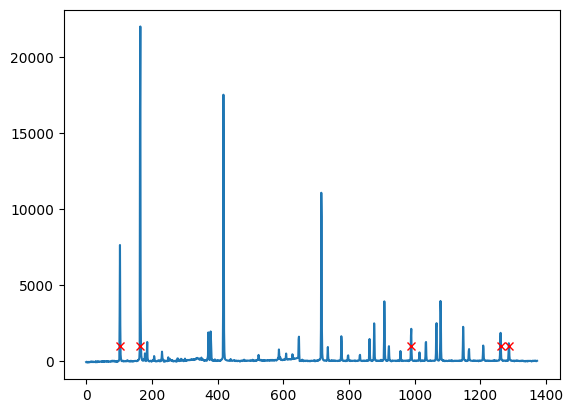

In [20]:
plt.plot(spectrum)
plt.plot(better_xvals, [1000]*len(better_xvals), 'x', color='red')

Redo the linear fit to see if we are on track. If we've identified the lines correctly, the points should lie close to the line. Misidentifications show up as points that are waaay off the line. 

In [21]:
# try a linear model first to see if we have identified the lines correctly 
linfit_linmodel_full = linfitter(model=linmodel, x=better_xvals, y=more_guessed_wavelengths)
more_wavelengths = linfit_linmodel_full(np.arange(len(spectrum))) * u.AA
linfit_linmodel_full

<Linear1D(slope=1.51573954, intercept=4765.84133842)>

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_3918/2593512324.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda(x)$")


Text(0.5, 0, 'x (pixels)')

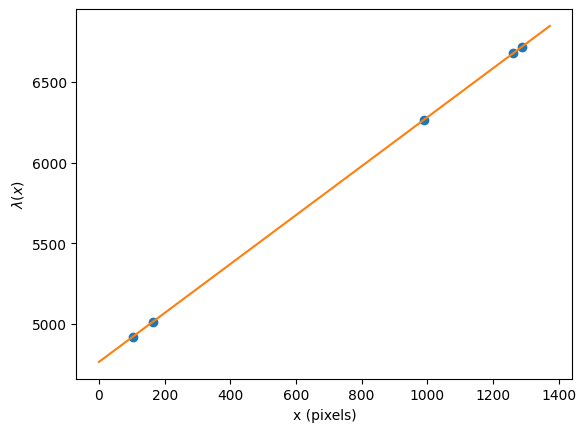

In [22]:
# input guesses 
plt.plot(better_xvals, more_guessed_wavelengths, 'o')
# derived wavelength solution
plt.plot(np.arange(len(spectrum)), more_wavelengths)
plt.ylabel("$\lambda(x)$")
plt.xlabel("x (pixels)")

We can use the wavelength solution that we just computed to estimate the position of the other lines in the combined lamp spectrum. 

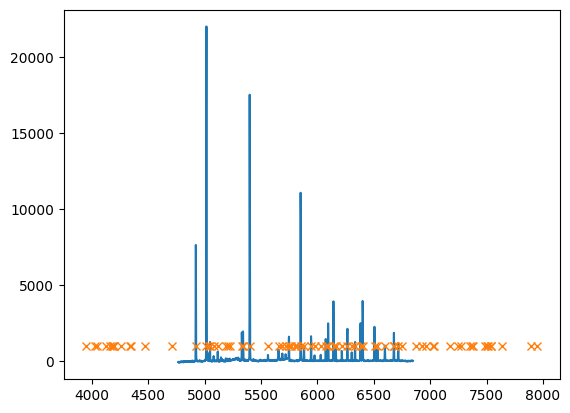

In [23]:
# use the linear fit from the HeI lamp to estimate the wavelength solution. 
all_wavelengths = linfit_linmodel_full(np.arange(len(spectrum))) * u.AA

plt.plot(all_wavelengths, spectrum)
plt.plot(linelist['wave'], [1000]*len(linelist['wave']), 'x')

Note that some of the lines fall outside the wavelength range that we observed. We can zoom in to see if the lines are close to where we expect. 

(5000.0, 7000.0)

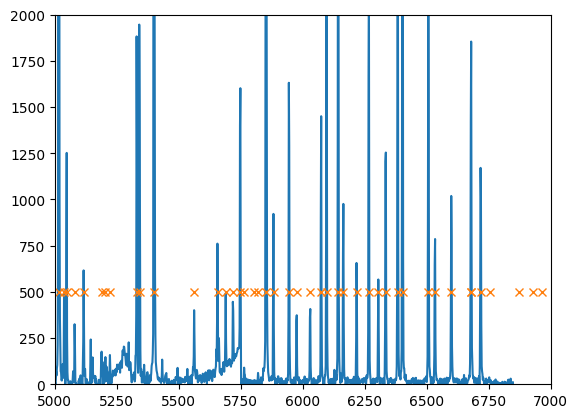

In [24]:
plt.Figure(figsize=(24,16))

plt.plot(all_wavelengths, spectrum)
plt.plot(linelist['wave'], [500]*len(linelist['wave']), 'x')
plt.ylim([0,2000])
plt.xlim([5000,7000])

If this worked, then the little orange 'x's should be more or less over the center of the emission line. 

We can use this first fit to help us guess the position of the other lines. To do this, we convert the wavelengths of the lines to the expected pixel position using the slope and the intercept of the linear fit. 

In [25]:
# make the expected wavelengths the first guess
make_x = np.floor((linelist['wave'] - linfit_linmodel_full.intercept.value) / linfit_linmodel_full.slope.value)
# exclude lines that fall outside the pixel range of our data
w_in_data = np.where((make_x>0) & (make_x<xaxis.max()))
guess_x = make_x[w_in_data]

Let's plot the inferred x values on the original data to make sure things are still behaving as expected. 

(0.0, 1000.0)

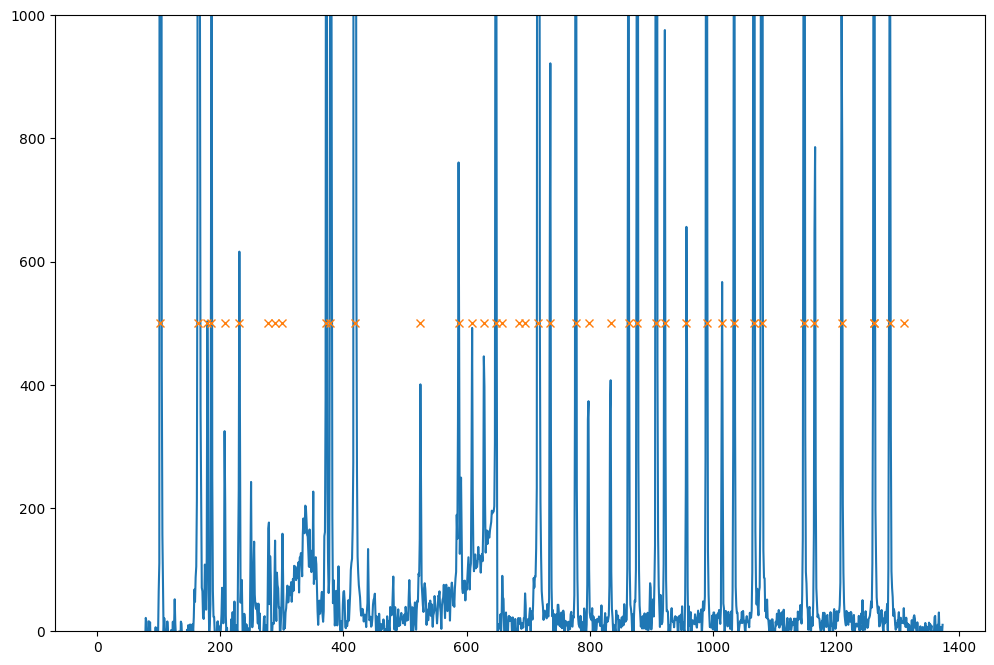

In [26]:
plt.figure(figsize=(12,8))
plt.plot(spectrum)
plt.plot(guess_x, [500]*len(guess_x), 'x')
plt.ylim([0,1000])

Be sure to zoom in and check a few portions of the spectrum to make sure that the 'x's don't fall outside the line or too close to another line as this will definitely mess up the fit. 

(800.0, 1000.0)

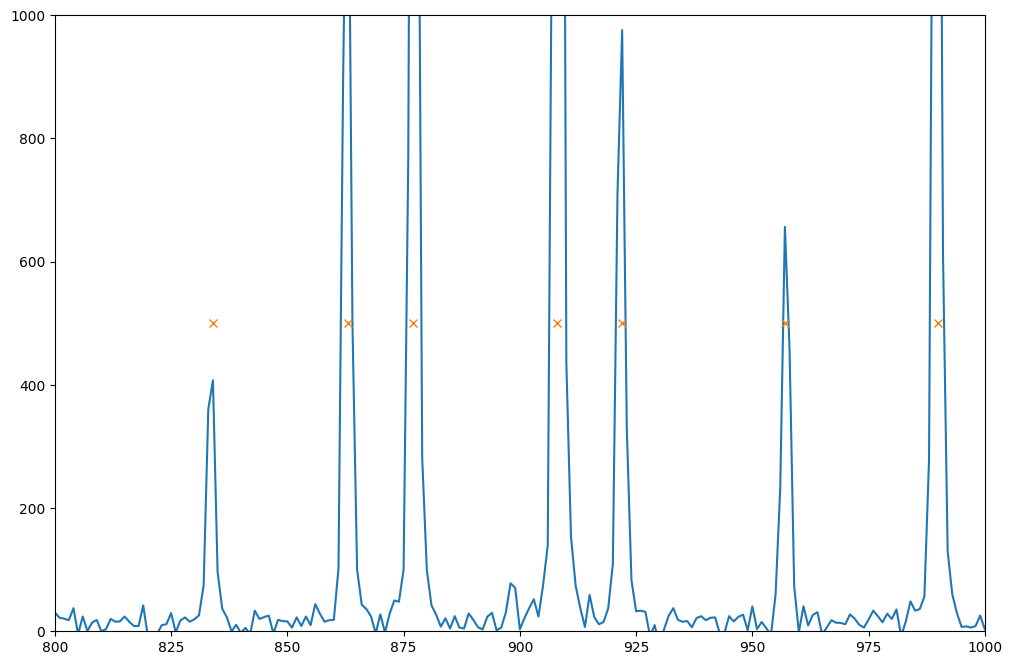

In [27]:
plt.figure(figsize=(12,8))
plt.plot(spectrum)
plt.plot(guess_x, [500]*len(guess_x), 'x')
plt.ylim([0,1000])
plt.xlim([800,1000])

Next, we'll fit a Gaussian to every line using these positions as the starting guess. You can and should zoom in on different parts of the spectrum to see how well the fit worked. Are the peaks in the right place? Are there any lines that were not detected? What did the fitter do in that case?

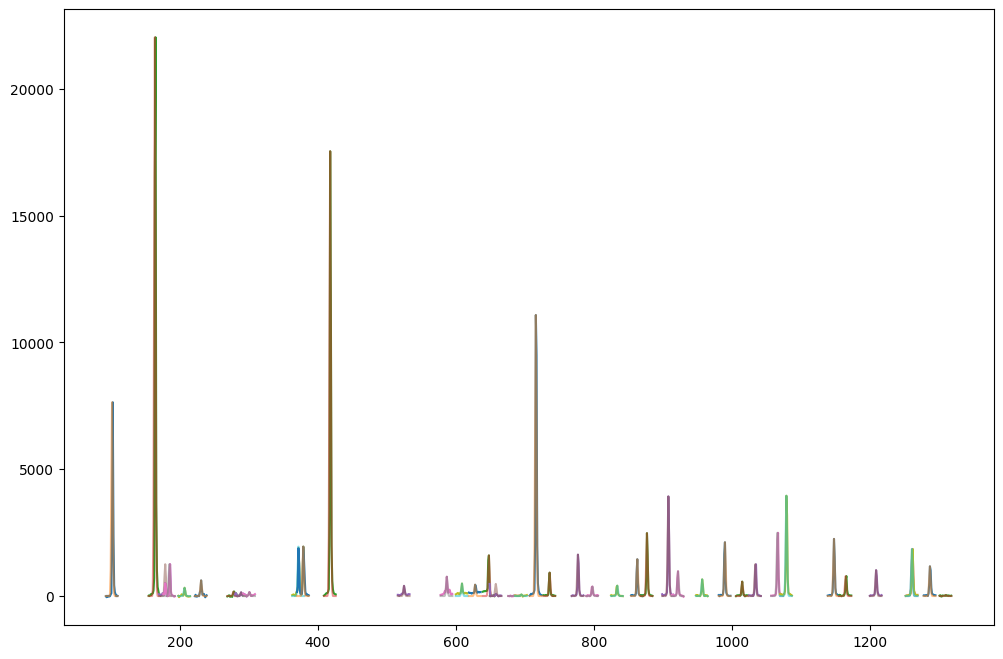

In [28]:
plt.figure(figsize=(12,8))

better_x = []
fit_t = TRFLSQFitter()

for g in guess_x.astype(int):
    sigma = 1
    g_init = Gaussian1D(amplitude=spectrum[g-npixels:g+npixels].max(), mean=g, stddev=sigma)
    xx = xaxis[g-npixels:g+npixels]
    plt.plot(xx, spectrum[g-npixels:g+npixels])
    fit = fit_t(g_init, xx, spectrum[g-npixels:g+npixels])
    better_x.append(fit.mean.value)
    p = plt.plot(xx, g_init(xx), alpha=0.5)#, label=str(i))

better_x = np.array(better_x)

Double check that the fits are close to the guessed position (i.e. that the code didn't fit another nearby line, etc)

(0.0, 1000.0)

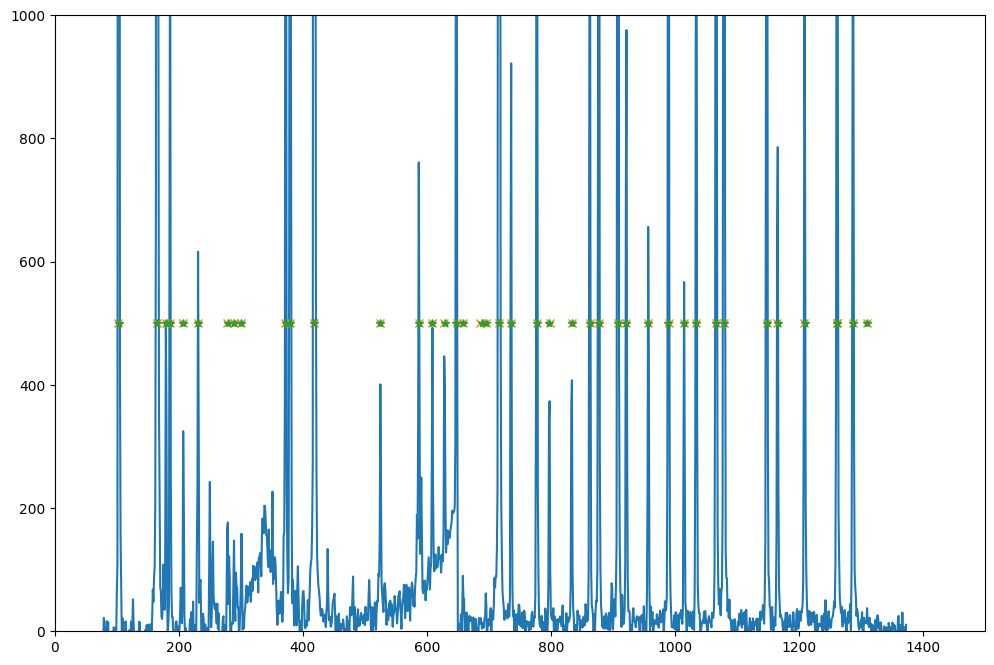

In [29]:
plt.figure(figsize=(12,8))

# if you are running this as a jupyter notebook locally on your machine
# uncomment the line below to make the plot interactive so you can zoom and pan to look at the line positions
#%matplotlib ipympl

# for colab, ... 

plt.plot(spectrum)
plt.plot(guess_x, [500]*len(guess_x), 'x')
plt.plot(better_x, [500]*len(guess_x), '*')
plt.xlim([0,1500])
plt.ylim([0,1000])

Now, fit the wavelength solution using _all_ of the lines. 

In [30]:
# refit now using the whole spectrum 
full_linfit_linmodel = linfitter(model=linmodel, x=better_x, y=linelist['wave'][w_in_data])
new_wavelengths = full_linfit_linmodel(np.arange(len(spectrum))) * u.AA
full_linfit_linmodel

<Linear1D(slope=1.51578859, intercept=4766.11699383)>

Plot the spectrum to see how we did.

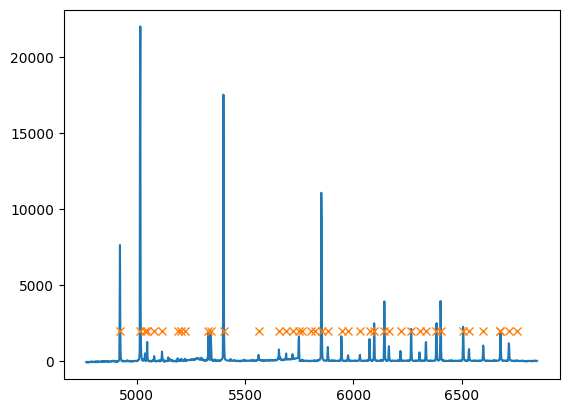

In [31]:
plt.plot(new_wavelengths, spectrum)
plt.plot(linelist['wave'][w_in_data], [2000]*len(linelist['wave'][w_in_data]), 'x')

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_3918/3824773639.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda(x)$")


Text(0.5, 0, 'x (pixels)')

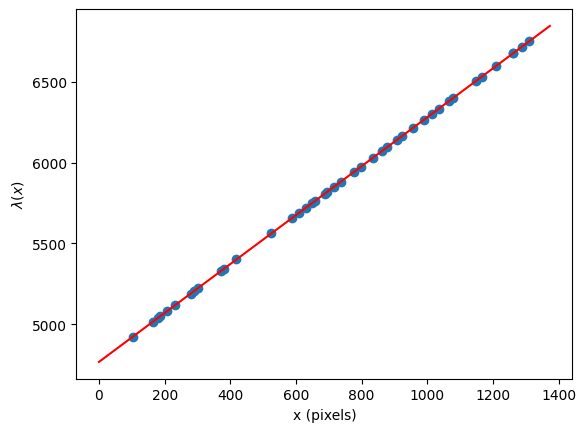

In [32]:
plt.plot(better_x, linelist['wave'][w_in_data], 'o')
plt.plot(xaxis, new_wavelengths, color='red')
plt.ylabel("$\lambda(x)$")
plt.xlabel("x (pixels)")

This looks pretty good - let's plot the residuals for a more precise look.

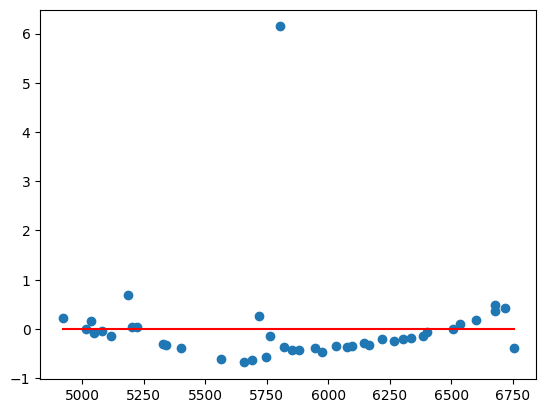

In [33]:
residuals_full_lamp_model = np.array(full_linfit_linmodel(better_x) - linelist['wave'][w_in_data])

plt.plot(linelist['wave'][w_in_data], residuals_full_lamp_model, 'o')
plt.plot(linelist['wave'][w_in_data], np.zeros(len(linelist['wave'][w_in_data])), color='red')

At least one point is a clear outlier and should be excluded from the fit. We can try to identify the offending points by looking through the list by hand (ugh) or we can use np.where to search for the points that have large residuals. 

In [34]:
# one of these is not like the others... 
residuals_full_lamp_model

array([ 2.24933616e-01, -2.64065820e-03,  1.63379940e-01, -8.57768308e-02,
       -4.43825771e-02, -1.41290121e-01,  6.92217679e-01,  4.46641204e-02,
        3.37977326e-02, -3.08507520e-01, -3.17621691e-01, -3.84100674e-01,
       -6.07699541e-01, -6.81834770e-01, -6.38563745e-01,  2.69195999e-01,
       -5.61594760e-01, -1.51255896e-01,  6.14463904e+00, -3.77088142e-01,
       -4.21481849e-01, -4.25420750e-01, -3.90456645e-01, -4.78752499e-01,
       -3.56662185e-01, -3.74740065e-01, -3.39726720e-01, -2.80237061e-01,
       -3.21042731e-01, -2.00915576e-01, -2.46875357e-01, -2.10636820e-01,
       -1.78272697e-01, -1.44056525e-01, -7.00042147e-02, -2.50305402e-03,
        9.09206155e-02,  1.72318949e-01,  4.95195786e-01,  3.70195786e-01,
        4.33045554e-01, -3.90363148e-01])

See it? Confirm your suspicions with np.where...

In [35]:
wbad = np.where(np.abs(residuals_full_lamp_model) >= 1.)

In [36]:
wbad

(array([18]),)

In [37]:
residuals_full_lamp_model[wbad]

array([6.14463904])

This tells us which indices to exclude. Alternately, we can construct the search to find the values that we want to keep.

In [38]:
wgood = np.where(np.abs(residuals_full_lamp_model) <= 1.)

In [39]:
wgood

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41]),)

Let's try again only fitting the good points. 

In [40]:
# refit now using the whole spectrum 
full_linfit_linmodel = linfitter(model=linmodel, x=better_x[wgood], y=linelist['wave'][w_in_data][wgood])
new_wavelengths = full_linfit_linmodel(np.arange(len(spectrum))) * u.AA
full_linfit_linmodel

<Linear1D(slope=1.51574842, intercept=4766.29594297)>

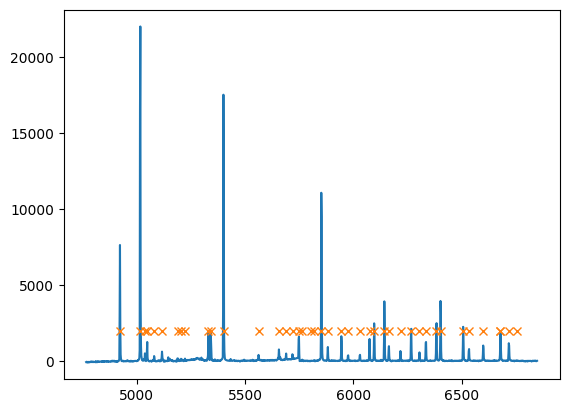

In [41]:
plt.plot(new_wavelengths, spectrum)
plt.plot(linelist['wave'][w_in_data], [2000]*len(linelist['wave'][w_in_data]), 'x')

This looks promising... let's check the fit and the residuals. 

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_3918/3824773639.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda(x)$")


Text(0.5, 0, 'x (pixels)')

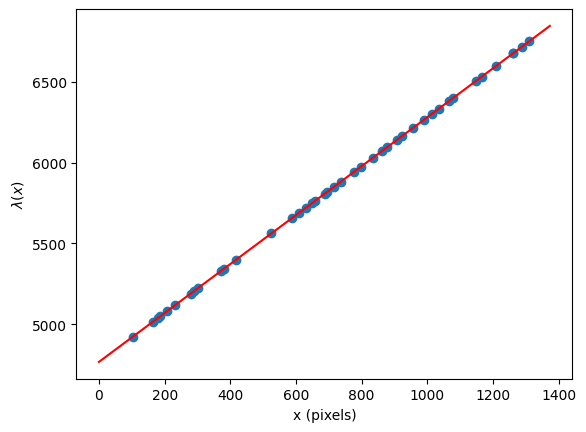

In [42]:
plt.plot(better_x, linelist['wave'][w_in_data], 'o')
plt.plot(xaxis, new_wavelengths, color='red')
plt.ylabel("$\lambda(x)$")
plt.xlabel("x (pixels)")

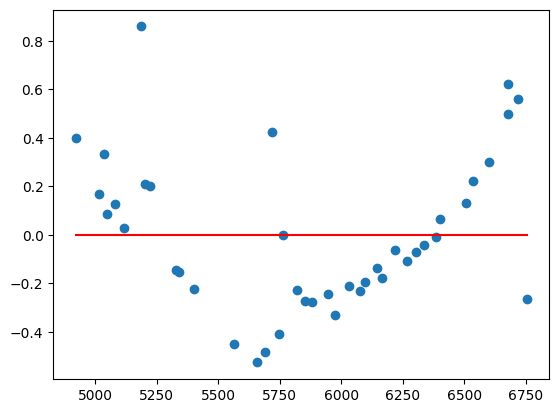

In [43]:
residuals_full_lamp_model = np.array(full_linfit_linmodel(better_x[wgood]) - linelist['wave'][w_in_data][wgood])

plt.plot(linelist['wave'][w_in_data][wgood], residuals_full_lamp_model, 'o')
plt.plot(linelist['wave'][w_in_data][wgood], np.zeros(len(linelist['wave'][w_in_data][wgood])), color='red')

This is better in the sense that most of the residuals are of a similar order now. 

This is clearly not great though because there is a lot of structure in the residuals. Ideally, values would be roughly equally and randomly distributed above and below zero. This is not the case with a linear fit, so let's try a higher order polynomial. 

## fitting a higher-order polynomial

The procedure for fitting a higher-order polynomial is much the same as the linear fit. The key difference is that we are using a different model to fit the data. 

In [44]:
# first, let's make new variables with the cleaned arrays since we've already done some trimming 
decent_xpos = better_x[wgood]
lines_to_fit = linelist['wave'][w_in_data][wgood]

In [45]:
# start with a Chebyshev polynomial 
poly_model = Chebyshev1D(degree=6)

masked_linfit_poly_model = linfitter(model=poly_model, x=decent_xpos, y=lines_to_fit)
masked_wavelength_poly = masked_linfit_poly_model(np.arange(len(spectrum))) * u.AA
masked_linfit_poly_model

<Chebyshev1D(6, c0=5837.37378549, c1=915.10222978, c2=-0.29069617, c3=0.02928371, c4=0.10973068, c5=0.02622634, c6=0.08933913, domain=(102.94241611043815, 1310.424260906595))>

As before, look at the resulting wavelengh solution a few different ways to see how we did. 

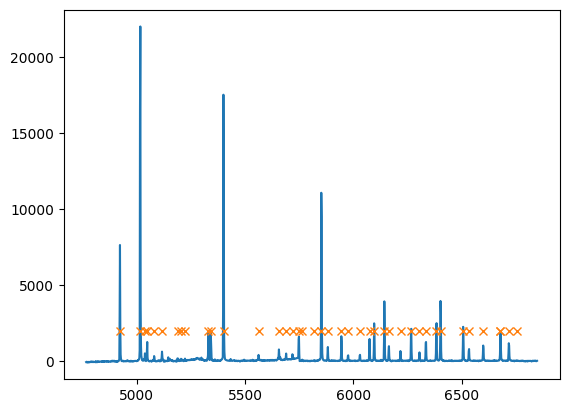

In [46]:
plt.plot(new_wavelengths, spectrum)
plt.plot(lines_to_fit, [2000]*len(lines_to_fit), 'x')

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_3918/1168097775.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda(x)$")


Text(0.5, 0, 'x (pixels)')

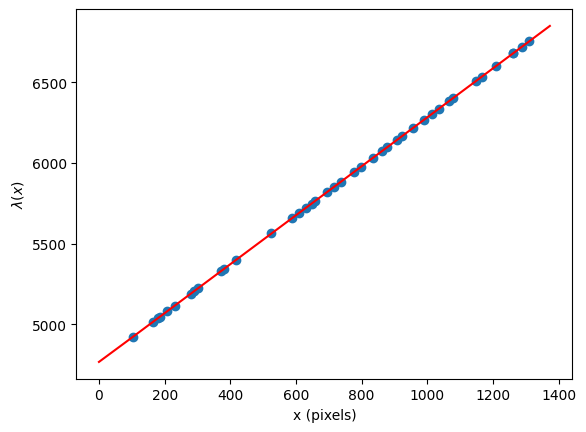

In [47]:
plt.plot(decent_xpos, lines_to_fit, 'o')
plt.plot(xaxis, masked_wavelength_poly, color='red')
plt.ylabel("$\lambda(x)$")
plt.xlabel("x (pixels)")

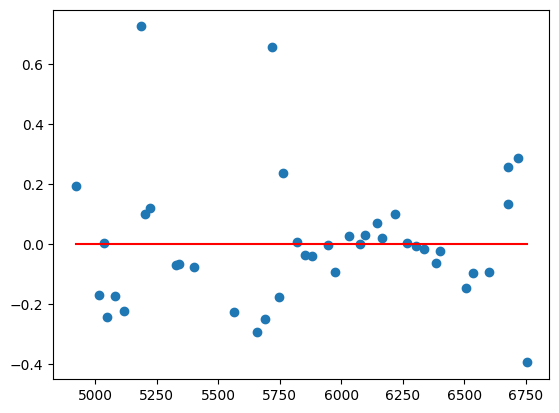

In [48]:
poly_residuals = np.array(masked_linfit_poly_model(decent_xpos) - lines_to_fit)

plt.plot(lines_to_fit, poly_residuals, 'o')
plt.plot(lines_to_fit, np.zeros(len(lines_to_fit)), color='red')

The residuals already look better (less structured). 

Try deleting a few outliers to see if the fit improves further. 

You can also trying playing around with the order of the fit and the type of polynomial. 

Finally, check the residuals. 

(array([ 4.,  4., 10.,  6.,  5.,  5.,  3.,  2.,  1.,  1.]),
 array([-0.52646932, -0.38782726, -0.24918521, -0.11054316,  0.0280989 ,
         0.16674095,  0.30538301,  0.44402506,  0.58266711,  0.72130917,
         0.85995122]),
 [<matplotlib.patches.Polygon at 0x14bc1f830>])

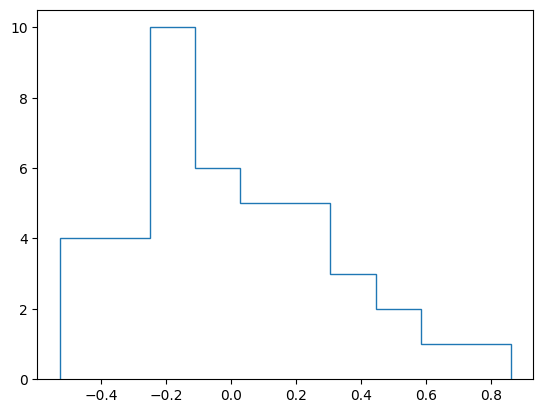

In [49]:
residuals_full_lamp_model = np.array(full_linfit_linmodel(decent_xpos) - lines_to_fit)
plt.hist(residuals_full_lamp_model, label='Full lamp fit', histtype='step')

If all went well, you should have an RMS of less than an Angstrom. If you don’t, check your line identifications. 

In [50]:
rms = np.sqrt(np.mean(residuals_full_lamp_model)**2)

In [51]:
rms

6.876667257307506e-13

After all that, the wavelength solution we just derived is only accurate along the row we defined as the "middle." Look at an image of the combined lamp spectrum. Notice that the lines are slightly tilted and curved. This means that in order to get an accurate wavelength solution that we can use no matter where our data fall on the CCD, we need to find the wavelength solution for different y-values on the detector. 

# Full wavelength solution. 

First, lets look again at our composite lamp spectrum. Notice that the lines are tilted and slightly curved. 

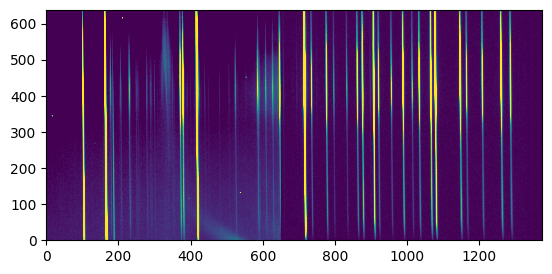

In [52]:
plt.imshow(spectrum2D, origin='lower', vmin=0, vmax=1500)

We will compute the wavelength solution for every row in the data. Below, we make the assumption that the tilt and curvature vary slowly so we can use the best-fit x-positions from the previous row as the starting guesses for the next row. Since we started with a slice through the middle of the data we'll do this in two parts: (1) starting in the middle and moving to the top of the chip and (2) starting in the middle and moving to the bottom. 

In [53]:
# fit wavelengths as the input coordinate 

yaxis=np.arange(spectrum2D.shape[0])
xvals=np.zeros([spectrum2D.shape[0],spectrum2D.shape[1]])
wavelengths = np.zeros((yaxis.shape[0],len(xaxis)))

xcntrs = np.zeros([spectrum2D.shape[0],w_in_data[0].shape[0]])
xcntrs[middle,:] = better_x
# 
slope = full_linfit_linmodel.slope.value
intercept = full_linfit_linmodel.intercept.value

# from middle to the top of the array 
last_guesses = (full_linfit_linmodel(guess_x) - intercept) / slope
wavelengths[middle,:] = new_wavelengths

for ii in yaxis[middle:]:
    improved_xguesses = [np.average(xaxis[g-npixels:g+npixels],
                                   weights=spectrum2D[ii,g-npixels:g+npixels])# - np.median(spectrum2D[ii,:]))
                        for g in np.floor(last_guesses).astype(int)]
    last_guesses = improved_xguesses
    xcntrs[ii,:] = improved_xguesses
    linfit_linmodel = linfitter(model=linmodel, x=improved_xguesses, y=linelist['wave'][w_in_data])
    xvals[ii,:] = (linfit_linmodel(xaxis) - intercept) / slope
    wv_fit = linfit_linmodel(xaxis) * u.AA
    wavelengths[ii,:] = wv_fit

# from middle to the bottom of the array 
last_guesses = better_x

for ii in np.arange(300)[::-1]:
    improved_xguesses = [np.average(xaxis[g-npixels:g+npixels],
                                   weights=spectrum2D[ii,g-npixels:g+npixels])# - np.median(spectrum2D[ii,:]))
                        for g in np.floor(last_guesses).astype(int)]
    last_guesses = improved_xguesses
    xcntrs[ii,:] = improved_xguesses
    linfit_linmodel = linfitter(model=linmodel, x=improved_xguesses, y=linelist['wave'][w_in_data])
    xvals[ii,:] = (linfit_linmodel(xaxis) - intercept) / slope
    wv_fit = linfit_linmodel(xaxis) * u.AA
    wavelengths[ii,:] = wv_fit


If everything went well, we should have an array with the same dimensions as our image with wavelengths increasing in the dispersion direction (to the right). 

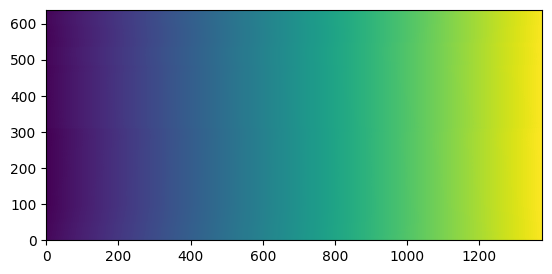

In [54]:
plt.imshow(wavelengths, origin='lower')

Finally, we can save the wavelength solution so that it is easy to use in subsequent steps. 

In [55]:
# make a header to store the units of the wavelength solution
hdr = fits.Header()
hdr['wvunit'] = 'Angstrom'

hdu = fits.PrimaryHDU(wavelengths, header=hdr)
hdul = fits.HDUList([hdu])
hdul.writeto('full_wave_sol.fits', overwrite=True)